# Writing a modal solver #


Basically modal analysis works, but the part where I try to work with PETSc matrices doesn't work. This might speed up calculations, if I understood correctly, but the problem is that it is a bit more complicated to work with than numpy or scipy.

UPDATE 4/7/2017
I studied a bit this PETSc thing, it was a looooong day. Why is it not documented for petsc4py??? *cries in binary*
Anyway, I added some functions to work with PETSc matrices, I'll add more in the next days. Also, I'll do all convergence things and 

In [2]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from petsc4py import PETSc
import time

# print PETSc matrix
def print_matrix(A, m, n):
    for i in range(m):
        for j in range(n):
            print A[i, j], "\t",
        print "\n"
    print "\n"   
    
    return

# Get csr data from a array of shape (m,n)
def get_csr_data(mat):
    (m, n) = np.shape(mat)
    tol = 1e-8
    
    indptr = [0]
    indices = []
    data = []
    count = 0
    
    for i in range(m):
        for j in range(n):
            if mat[i, j] > tol:
                count += 1
                indices.append(j)
                data.append(mat[i, j])
        indptr.append(count)
        
    return (m, n), indptr, indices, data

# Make PETSc matrix from given dense matrix mat
def make_petsc_matrix(mat):   
    if not mat.any():
        # mat is empty
        print "Empty matrix!"
    else:
        # mat is not empty so we make csr data
        shape_, indptr, indices, data = get_csr_data(mat)
        A = PETSc.Mat().createAIJ(size = shape_, csr = (indptr, indices, data))     
    
    return A

# testing PETSc
m = 3
n = 3
mat = np.zeros(shape = (m, n))
mat[0,1] = 1.0
mat[2,2] = 4.0
mat[1,2] = 58.0

mat2 = np.zeros(shape = (n, m))
mat2[1,0] = 2.0
mat2[1,1] = 14.0
mat2[2,2] = 5.0

A = make_petsc_matrix(mat)
B = make_petsc_matrix(mat2)

print_matrix(A, m, n)
C = A.matMult(B)
print_matrix(C, m, n)

# print dir(A) # all class functions

0.0 	1.0 	0.0 	

0.0 	0.0 	58.0 	

0.0 	0.0 	4.0 	



2.0 	14.0 	0.0 	

0.0 	0.0 	290.0 	

0.0 	0.0 	20.0 	





In [3]:
h = 32
mesh = UnitSquareMesh(h, h)   # generate mesh
V = FunctionSpace(mesh, 'P', 1)    # create finite element function space V, based on linear Lagrange elements
# plot(mesh)

f_exp = Expression('2*pi*pi * sin(pi*x[0]) * sin(pi*x[1])', degree=4)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
u_D = Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=4)
bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Get eigenvectors
neigs=10

uh = Function(V)

# set up matrices and assemble systen
A = PETScMatrix()
b = PETScVector()
assemble_system(a, L, bc, A_tensor=A, b_tensor=b)

# print A # <PETScMatrix of size 1089 x 1089>

# Extract and plot modes
solver = SLEPcEigenSolver(A)
solver.parameters["spectrum"] = "target magnitude"
solver.parameters["spectral_transform"] = "shift-and-invert"
solver.parameters["spectral_shift"] = 0.
solver.solve(neigs)

modes=[]
eigvalues=[]
vtkfile = File('Modes/modes.pvd')  
for md in range(neigs):
    r, c, rx, cx = solver.get_eigenpair(md)
    # Initialize function and assign eigenvector
    if not (r > 1.-1.e-8 and r < 1.+1.e-8):    # filter out spurious eigenvectors
        mode = Function(V)
        mode.rename("mode",'mode')
        mode.vector()[:] = rx
        modes.append(mode)
        eigvalues.append(r)
        # Save mode to file
        vtkfile << (mode, r)    
        del(mode)

l_vec = len(modes[0].vector().array())
nmodes = len(modes)
# print type(modes[0].vector()) # <class 'dolfin.cpp.la.GenericVector'> <PETScVector of size 1089>
# print dir(modes[0].vector()) # all class functions

In [62]:
# ignore this part
B = A.copy()
A.get(B, neigs, np.arange(neigs))

vec = modes[0].vector()
print dir(A) # all class function for GenericMatrix B/C it's somehow not the same as PETScMatrix ?!?!?!?! -.-
vec2 = vec
A.init_vector(vec2, 0)
# print type(vec2)
# A.mult(vec,vec2)
vec2 = A * modes
print vec2

TypeError: contiguous numpy array of 'double' expected. Make sure that the numpy array is contiguous, and uses dtype=float_.

In [4]:
# Modal projection using numpy
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

K = np.dot(np.dot(mode_array.T, A.array()), mode_array)
F = np.dot(mode_array.T, b.array())

C = np.linalg.solve(K, F)

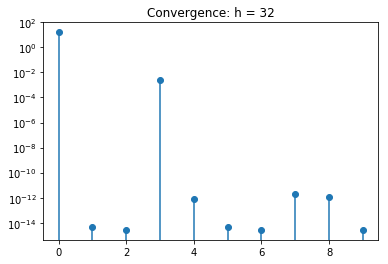

In [12]:
plt.stem(abs(C))
plt.title('Convergence: h = %s'%h)
plt.yscale('log')
plt.show()

In [13]:
# Extract modes and set up modal matrices in NumPy with vectorial multiplication
nmodes = len(modes)
l_vec = len(modes[0].vector().array())
M1 = np.zeros([nmodes, nmodes])
K1 = np.zeros([nmodes, nmodes])
F1 = np.zeros(nmodes)

# Project problem on modal basis - brute force
for i in range(nmodes):
    F1[i] = np.dot(b.array(), modes[i].vector())
    for j in range(nmodes):
        K1[i,j]= np.dot(modes[i].vector(), np.dot(A.array(), modes[j].vector()))
 

In [14]:
# Extract modes and set up modal matrices with PETSc

# Set up PETSc matrix
mode_mat = PETSc.Mat().create()
mode_mat.setSizes([l_vec, nmodes])
mode_mat.setType("dense")
mode_mat.setUp()

# First arg is list of row indices, second list of column indices
mode_mat.setValues(range(l_vec), range(nmodes), mode_array.T)
mode_mat.assemble()

# get the matrix array by: mode_mat.getDenseArray()
A_modes = PETScMatrix(mode_mat)

In [15]:
# Create a transposed matrix of the modes
# Transposing a PETSc matrix doesn't work for me
#    >:(
#

# Set up PETSc matrix
mode_mat2 = PETSc.Mat().create()
mode_mat2.setSizes([nmodes, l_vec])
mode_mat2.setType("dense")
mode_mat2.setUp()

# First arg is list of row indices, second list of column indices
mode_mat2.setValues(range(nmodes), range(l_vec), mode_array)
mode_mat2.assemble()

In [16]:
A_m = PETScMatrix(A.mat().matMult(mode_mat))

# A_modes.mat().matMult(A.mat().MatMultTranspose(A_modes.mat()))

#help(A.mat().matMult)
#A.mat().matMult(mode_mat, result=A_m.mat())

test = A_m.mat()
test2 = mode_mat2.matMult(test)

# test with K matrix:
print("test norm: ", np.linalg.norm(test2.getDenseArray() - K) / np.linalg.norm(test2.getDenseArray()))

('test norm: ', 11.342719067364675)
